# Experiment 05

From Experiment 04 but instead using with_arrows dataset

1. load all dataset ['lanefollow', 'straight', 'right', 'left']
    - Train/Test: 60/40
2. model build according to the paper  
    1. image module: activation elu
    2. the rest module: activation relu
    3. final layer: activation sigmoid
    
3. hyperparameter
    1. nb_epoch = 20
    2. samples_per_epoch = 40000
    3. batch_size = 40
    4. learning_rate 1.0e-4
    
### What does it change?
- re-range steering_angle from: -1.0 - 1.0 to 0.0 - 0.2


### The Problem
- model is overfitting
    

In [1]:
%reload_ext autoreload

In [2]:
%autoreload 2

In [71]:
import pandas as pd # data analysis toolkit - create, read, update, delete datasets
import numpy as np # matrix math
from sklearn.model_selection import train_test_split #to split out training and testing data 
#keras is a high level wrapper on top of tensorflow (machine learning library)
#The Sequential container is a linear stack of layers
from keras.models import Sequential, Model
#popular optimization strategy that uses gradient descent 
from keras.optimizers import Adam
#to save our model periodically as checkpoints for loading later
from keras.callbacks import ModelCheckpoint, EarlyStopping
#what types of layers do we want our model to have?
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling1D, Dense, Flatten, LSTM, Activation, ZeroPadding2D, TimeDistributed, Input, concatenate, Reshape
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
#for command line arguments
import argparse
#for reading files
import os
#for ploting graph
import matplotlib.pyplot as plt
import timeit
import math

In [72]:
import nbimporter # pip install nbimporter
import utils as utils
import importlib
importlib.reload(utils)

Importing Jupyter notebook from utils.ipynb


<module 'utils' from 'utils.ipynb'>

In [73]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

In [74]:
def load_data(folder_name, test_size_value=0.4):
    """
    Load training data and split it into training and validation set
    """
    #reads CSV file into a single dataframe variable
    data_df = pd.read_csv(os.path.join('../..', '_out', folder_name, 'train_3/data.csv'))

    #yay dataframes, we can select rows and columns by their names
    #we'll store the camera images as our input data
    X = data_df[['image_path', 'speed', 'high_level_command']].values
    #and our steering commandas as our output data
    Y = data_df[['throttle', 'steering_angle', 'brake']].values
    
    X_lanefollow = []
    X_straight = []
    X_left = []
    X_right = []
    
    Y_lanefollow = []
    Y_straight = []
    Y_left = []
    Y_right = []
    
    X_image_path = X[:, 0]
    index = 0
    for path in X_image_path:
        path = path.split('/')
        if path[3] == 'lanefollow':
            X_lanefollow.append(X[index])
            Y_lanefollow.append(Y[index])
        elif path[3] == 'straight':
            X_straight.append(X[index])
            Y_straight.append(Y[index])
        elif path[3] == 'left':
            X_left.append(X[index])
            Y_left.append(Y[index])
        elif path[3] == 'right':
            X_right.append(X[index])
            Y_right.append(Y[index])
        index += 1
        
    X_lanefollow = np.array(X_lanefollow)
    X_straight = np.array(X_straight)
    X_left = np.array(X_left)
    X_right = np.array(X_right)
    
    Y_lanefollow = np.array(Y_lanefollow)
    Y_straight = np.array(Y_straight)
    Y_left = np.array(Y_left)
    Y_right = np.array(Y_right)
    # we're going to use all training data so, we will use only len(X_train) * 40 / 60 of validating data
    # so, our ratio is going to be 60% for training set and 40% for validation set and for testing
    # we're going to test in the simulation environment which is town01
    X_train_lanefollow, X_valid_lanefollow, Y_train_lanefollow, Y_valid_lanefollow = train_test_split(X_lanefollow, Y_lanefollow, test_size=0.4, random_state=2)
    X_train_straight, X_valid_straight, Y_train_straight, Y_valid_straight         = train_test_split(X_straight, Y_straight, test_size=0.4, random_state=2)
    X_train_left, X_valid_left, Y_train_left, Y_valid_left                         = train_test_split(X_left, Y_left, test_size=0.4, random_state=2)
    X_train_right, X_valid_right, Y_train_right, Y_valid_right                     = train_test_split(X_right, Y_right, test_size=0.4, random_state=2)
    
    X_train = [X_train_lanefollow, X_train_straight, X_train_left, X_train_right]
    Y_train = [Y_train_lanefollow, Y_train_straight, Y_train_left, Y_train_right]
    
    X_valid = [X_valid_lanefollow, X_valid_straight, X_valid_left, X_valid_right]
    Y_valid = [Y_valid_lanefollow, Y_valid_straight, Y_valid_left, Y_valid_right]
    
    print('X_train shape = (%d, %d)'% ((X_train[0].shape[0] + X_train[1].shape[0] + X_train[2].shape[0] + X_train[3].shape[0]), 4))
    print('Y_train shape = (%d, %d)'% ((Y_train[0].shape[0] + Y_train[1].shape[0] + Y_train[2].shape[0] + Y_train[3].shape[0]), 4))
    print('X_valid shape = (%d, %d)'% ((X_valid[0].shape[0] + X_valid[1].shape[0] + X_valid[2].shape[0] + X_valid[3].shape[0]), 4))
    print('Y_valid shape = (%d, %d)'% ((Y_valid[0].shape[0] + Y_valid[1].shape[0] + Y_valid[2].shape[0] + Y_valid[3].shape[0]), 4))

    return X_train, X_valid, Y_train, Y_valid

In [97]:
def build_model(args):
    
    input_image = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), name='input_image')
    input_speed = Input(shape=(1, ), name='input_speed')
    input_command = Input(shape=(1, ), name='input_command')
    
    """conv 1"""
    xc = Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding="valid", name='conv_1_1')(input_image)
    xc = BatchNormalization()(xc)
    xc = Activation('elu')(xc)
    
    xc = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid", name='conv_1_2')(xc)
    xc = BatchNormalization()(xc)
    xc = Activation('elu')(xc)
    
    """conv 2"""
    xc = Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding="valid", name="conv_2_1")(xc)
    xc = BatchNormalization()(xc)
    xc = Activation('elu')(xc)
    
    xc = Conv2D(64, kernel_size=(3,3), strides=(1, 1), padding="valid", name="conv_2_2")(xc)
    xc = BatchNormalization()(xc)
    xc = Activation('elu')(xc)
    
    """conv 3"""
    xc = Conv2D(128, kernel_size=(3,3), strides=(2, 2), padding="valid", name="conv_3_1")(xc)
    xc = BatchNormalization()(xc)
    xc = Activation('elu')(xc)
    
    xc = Conv2D(128, kernel_size=(3,3), strides=(1, 1), padding="valid", name="conv_3_2")(xc)
    xc = BatchNormalization()(xc)
    xc = Activation('elu')(xc)
    
    """conv 4"""
    xc = Conv2D(256, kernel_size=(3,3), strides=(1, 1), padding="valid", name="conv_4_1")(xc)
    xc = BatchNormalization()(xc)
    xc = Activation('elu')(xc)

    xc = Conv2D(256, kernel_size=(1,1), strides=(1, 1), padding="valid", name="conv_4_2")(xc)
    xc = BatchNormalization()(xc)
    xc = Activation('elu')(xc)
    xc = Dropout(0.2)(xc)

    """Flatten"""
    x = Flatten()(xc)
    
    """fc 1"""
    x = Dense(512, name="fc_1")(x)
    x = Activation('elu')(x)
    x = Dropout(0.5)(x)
    
    """fc 2"""
    x = Dense(512, name="fc_2")(x)
    x = Activation('elu')(x)
    x = Dropout(0.5)(x)
    
    """Process Control"""
    
    """Speed (measurements)"""
    speed = Dense(128, name="speed_fc_1")(input_speed)
    speed = Activation('relu')(speed)
    speed = Dropout(0.5)(speed)
    
    speed = Dense(128, name="speed_fc_2")(speed)
    speed = Activation('relu')(speed)
    spped = Dropout(0.5)(speed)
    
    """High Level Command"""
    cmd = Dense(128, name="cmd_fc_1")(input_command)
    cmd = Activation('relu')(cmd)
    cmd = Dropout(0.5)(cmd)
    
    cmd = Dense(128, name="cmd_fc_2")(cmd)
    cmd = Activation('relu')(cmd)
    cmd = Dropout(0.5)(cmd)

    # concatenate x, speed and cmd (joint sensory)
    j = concatenate([x, speed, cmd])
    j = Dense(512, name="joint_fc")(j)
    j = Activation('relu')(j)
    j = Dropout(0.5)(j)
    
    """Action"""
    output = Reshape(target_shape=(-1, 1))(j)
    output = LSTM(128, return_sequences=True, name="action_fc_1")(output)
    output = Dropout(0.5)(output) 
    
    output = LSTM(128, return_sequences=True, name="action_fc_2")(output)
    output = Dropout(0.5)(output) 
    
    output = Flatten()(output)
    
    output = Dense(3, name="action_fc_4", activation='sigmoid')(output)
        
    model = Model(inputs=[input_image, input_speed, input_command], outputs=output)
    model.summary()

    return model

In [98]:
def train_model(model, args, X_train, X_test, Y_train, Y_test):
    """
    Train the model
    """
    #Saves the model after every epoch.
    #quantity to monitor, verbosity i.e logging mode (0 or 1), 
    #if save_best_only is true the latest best model according to the quantity monitored will not be overwritten.
    #mode: one of {auto, min, max}. If save_best_only=True, the decision to overwrite the current save file is
    # made based on either the maximization or the minimization of the monitored quantity. For val_acc, 
    #this should be max, for val_loss this should be min, etc. In auto mode, the direction is automatically
    # inferred from the name of the monitored quantity.
    callbacks = [EarlyStopping(monitor='val_loss', patience=2),
                 ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=args['save_best_only'],
                                 mode='auto')]
    #calculate the difference between expected steering angle and actual steering angle
    #square the difference
    #add up all those differences for as many data points as we have
    #divide by the number of them
    #that value is our mean squared error! this is what we want to minimize via
    #gradient descent
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=args['learning_rate']), metrics=['accuracy'])

    #Fits the model on data generated batch-by-batch by a Python generator.

    #The generator is run in parallel to the model, for efficiency. 
    #For instance, this allows you to do real-time data augmentation on images on CPU in 
    #parallel to training your model on GPU.
    #so we reshape our data into their appropriate batches and train our model simulatenously
    history = model.fit_generator(utils.batch_generator(X_train, Y_train, args['batch_size'], True, 4),
                        args['samples_per_epoch'],
                        args['nb_epoch'],
                        max_q_size=1,
                        validation_data=utils.batch_generator(X_valid, Y_valid, args['batch_size'], False, 4),
                        nb_val_samples=X_valid[0].shape[0],
                        callbacks=callbacks,
                        verbose=1)

    return history

In [99]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["acc"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_acc"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)

In [104]:
args = {
        'nb_epoch': 1,
        'samples_per_epoch': 40000,
        'batch_size': 40,
        'save_best_only': True,
        'learning_rate': 1.0e-4
}

# build model
model = build_model(args)
X_train, X_valid, Y_train, Y_valid = load_data('no_obstacle_no_traffic')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 66, 200, 3)   0                                            
__________________________________________________________________________________________________
conv_1_1 (Conv2D)               (None, 31, 98, 32)   2432        input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization_153 (BatchN (None, 31, 98, 32)   128         conv_1_1[0][0]                   
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 31, 98, 32)   0           batch_normalization_153[0][0]    
__________________________________________________________________________________________________
conv_1_2 (

X_train shape = (50869, 4)
Y_train shape = (50869, 4)
X_valid shape = (33917, 4)
Y_valid shape = (33917, 4)


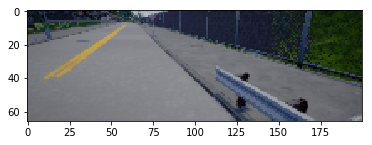

In [105]:
utils.show_image(utils.load_image(X_train[2][90][0]))

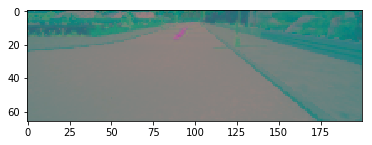

In [106]:
utils.show_image(utils.preprocess(utils.load_image(X_train[2][84][0])))

# Load train/validation data set and train the model

------------------------------
Parameters
------------------------------
batch_size           := 40
nb_epoch             := 1
save_best_only       := True
samples_per_epoch    := 40000
learning_rate        := 0.0001
------------------------------


/home/ploymel/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ploymel/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 40000, 1, validation_data=<generator..., max_queue_size=1, verbose=1, callbacks=[<keras.ca..., validation_steps=12002)`


Epoch 1/1
40000/40000 [==============================] - 59581s 1s/step - loss: 9.8440e-04 - acc: 0.9068 - val_loss: 6.4527e-04 - val_acc: 0.9283
------------------------------
Time use: 16 hours 33 minutes 15 seconds.
------------------------------


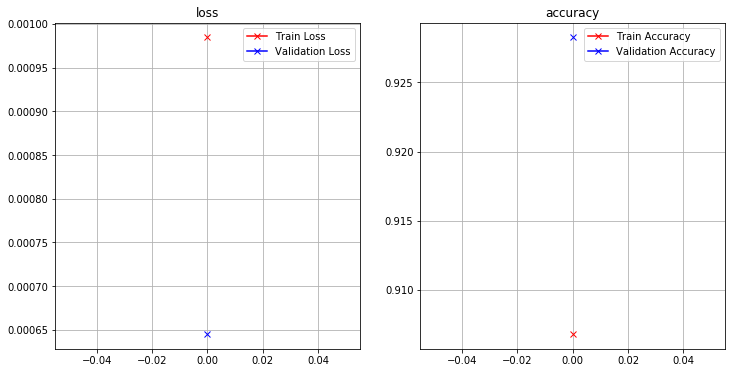

In [107]:
#print parameters
print('-' * 30)
print('Parameters')
print('-' * 30)
for key in args:
    print('{:<20} := {}'.format(key, args[key]))
print('-' * 30)

# train model on validation data, it saves as model.h5 
# Comment out when you finish validation and about to start the real training with test dataset
start = timeit.default_timer()
history = train_model(model, args, X_train, X_valid, Y_train, Y_valid)
stop = timeit.default_timer()
elasped = stop - start
hour = math.floor(elasped / 3600)
minute = math.floor((elasped - hour * 3600) / 60)
second = elasped - ((hour * 3600) + (minute * 60))
print('-' * 30)
print('Time use: %d hours %d minutes %d seconds.' % (hour, minute, second)) 
print('-' * 30)

# visualize training and validation
plot_loss_accuracy(history)

